In [108]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [109]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [110]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens5 == 1]
    counts = relapsed['Illicit_Days5'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [111]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

def run_models(X, y, label):
    gbsa = GradientBoostingSurvivalAnalysis()
    scores = cross_validate(gbsa, X, y, cv=5)
    gbsa_score = scores['test_score'].mean()
    print('RF Boosted score:', gbsa_score)
    
    gbsa = GradientBoostingSurvivalAnalysis()
    gbsa.fit(X, y)
    
    # selected via forward/backward feature selection
    """temp = X[["%_U18g","%_female_householdg","%_povertyg","B2a_0g","SESg_0_cd","cjsig_0_cd","dssg_0_cd","murder_numg",
              "primsev_cd_4","primsev_cd_5","primsev_cd_6","prsatx_cd","r4ag_0_cd","srig_0_cd","unemplmt_cd",
              "%_public_assistanceg","%_unemployedg","CWSg_0_cd","adhdg_0_cd","cdsg_0_cd","epsg_0_cd","female_cd",
              "lrig_0_cd","nonwhite_cd","primsev_cd_2","primsev_cd_3"]]"""
    rsf = RandomSurvivalForest()
    """scores = cross_validate(rsf, temp, y, cv=5)"""
    scores = cross_validate(rsf, X, y, cv=5)
    rsf_score = scores['test_score'].mean()
    print('RF score:', rsf_score)
    
    rsf = RandomSurvivalForest()
    """rsf.fit(temp, y)"""
    rsf.fit(X, y)
    
    # selected via forward/backward feature selection
    """temp = X[["%_U18g","%_female_householdg","%_unemployedg","SESg_0_cd","adhdg_0_cd","cdsg_0_cd","cjsig_0_cd",
              "dssg_0_cd","nonwhite_cd","primsev_cd_3","primsev_cd_4","primsev_cd_6","prsatx_cd","r4ag_0_cd",
              "srig_0_cd","epsg_0_cd","gvsg_cd","primsev_cd_1","primsev_cd_2","unemplmt_cd"]]"""
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    """scores = cross_validate(rcr, temp, y, cv=5)"""
    scores = cross_validate(rcr, X, y, cv=5)
    rcr_score = scores['test_score'].mean()
    print('Lasso score:', rcr_score)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    """rcr.fit(temp, y)"""
    rcr.fit(X, y)
    
    # concordance index
    scores = {'Model': ['Random Forest Boosted','Random Forest','Lasso','Dataset Size'], 
              label: [gbsa_score,rsf_score,rcr_score,X.shape[0]]}
    
    concordance = pd.DataFrame(data=scores)
    
    # return scores and models
    return concordance, gbsa, rsf, rcr

In [112]:
def get_survival_graph(rsf, rcr, X, Y, label, filename):
    """temp = X[["%_U18g","%_female_householdg","%_povertyg","B2a_0g","SESg_0_cd","cjsig_0_cd","dssg_0_cd","murder_numg",
              "primsev_cd_4","primsev_cd_5","primsev_cd_6","prsatx_cd","r4ag_0_cd","srig_0_cd","unemplmt_cd",
              "%_public_assistanceg","%_unemployedg","CWSg_0_cd","adhdg_0_cd","cdsg_0_cd","epsg_0_cd","female_cd",
              "lrig_0_cd","nonwhite_cd","primsev_cd_2","primsev_cd_3"]]
    pred_surv_rsf = rsf.predict_survival_function(temp)"""
    pred_surv_rsf = rsf.predict_survival_function(X)
    """temp = X[["%_U18g","%_female_householdg","%_unemployedg","SESg_0_cd","adhdg_0_cd","cdsg_0_cd","cjsig_0_cd",
              "dssg_0_cd","nonwhite_cd","primsev_cd_3","primsev_cd_4","primsev_cd_6","prsatx_cd","r4ag_0_cd",
              "srig_0_cd","epsg_0_cd","gvsg_cd","primsev_cd_1","primsev_cd_2","unemplmt_cd"]]
    pred_surv_rcr = rcr.predict_survival_function(temp)"""
    pred_surv_rcr = rcr.predict_survival_function(X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(Y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [113]:
def get_feature_importance(features, gbsa, rcr, label):
    # feature importances from Boosted Random Forest
    feature_importance_rf = pd.DataFrame({'Feature':features, label:gbsa.feature_importances_,})
    feature_importance_rf.sort_values(by=[label], ascending=False, inplace=True)
    feature_importance_rf = feature_importance_rf.nlargest(10,[label]) # keep top 10 features
    feature_importance_rf = feature_importance_rf[feature_importance_rf[label] != 0]

    # feature importances from Lasso
    """temp = ["%_U18g","%_female_householdg","%_unemployedg","SESg_0_cd","adhdg_0_cd","cdsg_0_cd","cjsig_0_cd",
              "dssg_0_cd","nonwhite_cd","primsev_cd_3","primsev_cd_4","primsev_cd_6","prsatx_cd","r4ag_0_cd",
              "srig_0_cd","epsg_0_cd","gvsg_cd","primsev_cd_1","primsev_cd_2","unemplmt_cd"]"""
    feature_importance_lasso = pd.DataFrame({'Feature':features, #temp,
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    feature_importance_lasso[label + '_abs'] = np.absolute(feature_importance_lasso[label])
    feature_importance_lasso = feature_importance_lasso.nlargest(10,[label + '_abs']) # keep top 10 features
    feature_importance_lasso = feature_importance_lasso[feature_importance_lasso[label] != 0]
    
    return feature_importance_rf, feature_importance_lasso

Survival Analysis by Severity

In [114]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset_stratified.csv')
df.drop(columns=['SDSl_0'], inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,nonillicit_flag,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,Address,lat,lng,state_name,county_FIPS_x,block_FIPS_x,murder_numg,block_FIPS_y,county_FIPS_y,gran,%_U18g,%_female_householdg,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,1,857,OH,Cleveland,1276 West Third St. #400,2005,365,0,0,0,0,0,2,0,0,1,1,1,1,0,1,2,0,1,1,1,0,0,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.419286,-81.701695,Ohio,39035.0,3.903511e+14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,929,OH,Cleveland,1276 West Third St. #400,2006,354,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,2,1,1,0,0,0,0,0,0,3,"1276 West Third St. #400, Cleveland, OH",41.419286,-81.701695,Ohio,39035.0,3.903511e+14,0.0,390351059002009,39035,0.0,0.0,1.0,0.0,0.0,0.0
2,2,2,3,951,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,1,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.419286,-81.701695,Ohio,39035.0,3.903511e+14,0.0,390351059002009,39035,0.0,0.0,1.0,0.0,0.0,0.0
3,3,3,4,1032,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,2,0,1,1,1,1,1,0,2,1,0,2,1,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.419286,-81.701695,Ohio,39035.0,3.903511e+14,0.0,390351059002009,39035,0.0,0.0,1.0,0.0,0.0,0.0
4,4,4,5,1039,OH,Cleveland,1276 West Third St. #400,2004,365,0,0,0,0,0,0,0,0,1,0,0,1,1,2,1,0,2,0,0,1,0,0,0,0,0,0,"1276 West Third St. #400, Cleveland, OH",41.419286,-81.701695,Ohio,39035.0,3.903511e+14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# subset to patients who have county level murder and socioeconomic data available
df.dropna(subset=['murder_numg','%_U18g'], inplace=True)
df.shape

(10025, 50)

In [116]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','block_FIPS_y','county_FIPS_y','county_FIPS_x','block_FIPS_x',
                'gran','srprobg_cd']

# uncomment to get CONTROL statistics
cols_to_drop = cols_to_drop + ['%_U18g','%_female_householdg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']

df.drop(columns=cols_to_drop, inplace=True)
#df.dropna(inplace=True)
df = df.astype(int)
df.dtypes

Illicit_Days5           int64
Illicit_Cens5           int64
female_cd               int64
nonwhite_cd             int64
unemplmt_cd             int64
prsatx_cd               int64
gvsg_cd                 int64
CWSg_0_cd               int64
dssg_0_cd               int64
epsg_0_cd               int64
adhdg_0_cd              int64
cdsg_0_cd               int64
cjsig_0_cd              int64
lrig_0_cd               int64
srig_0_cd               int64
SESg_0_cd               int64
r4ag_0_cd               int64
nonillicit_flag         int64
primsev_cd_1            int64
primsev_cd_2            int64
primsev_cd_3            int64
primsev_cd_4            int64
primsev_cd_5            int64
primsev_cd_6            int64
B2a_0g                  int64
SUDSy_0                 int64
murder_numg             int64
%_U18g                  int64
%_female_householdg     int64
%_unemployedg           int64
%_public_assistanceg    int64
%_povertyg              int64
dtype: object

In [117]:
# df = df[df.nonillicit_flag == 0] # subset to only the illicit cases
df.drop(columns=['nonillicit_flag'], inplace=True) # if not used to subset, remove feature since its redundant

In [118]:
df.shape

(10025, 31)

In [119]:
df.head()

,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,murder_numg,%_U18g,%_female_householdg,%_unemployedg,%_public_assistanceg,%_povertyg
1,354,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,2,1,0,0,0,0,0,0,3,0,0,1,0,0,0
2,365,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2,0,0,1,0,0,0
3,365,0,0,0,0,0,2,0,1,1,1,1,0,2,1,0,2,0,0,1,0,0,0,0,2,0,0,1,0,0,0
18,365,0,0,0,0,0,0,0,0,1,1,0,0,2,2,0,0,0,0,1,0,0,0,0,2,0,0,1,0,0,0
21,5,1,0,0,0,1,2,1,2,2,1,2,1,1,2,2,2,0,0,1,0,0,0,0,11,0,0,1,0,0,0


Full Population Survival Analysis

In [120]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days5'
censoring_var = 'Illicit_Cens5'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10025, 29) (10025,)


In [121]:
%%time
full_concordance, gbsa, rsf, rcr = run_models(X, y, 'ALL')

RF Boosted score: 0.6634352999396513
RF score: 0.6578936218160928
Lasso score: 0.6673938929543553
CPU times: user 10min 1s, sys: 4 s, total: 10min 5s
Wall time: 10min 11s


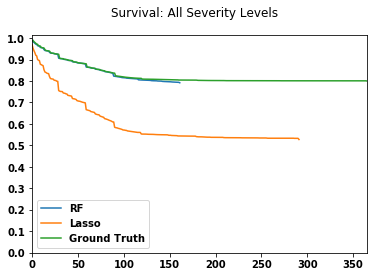

In [122]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: All Severity Levels','graphs/survival_all.png')

Subclinical Severity Survival Analysis

In [123]:
X = df[df.SUDSy_0 < 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3243, 28) (3243,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [124]:
%%time
subclinical_concordance, gbsa, rsf, rcr = run_models(X, y, 'SUB')

RF Boosted score: 0.6365269986681004
RF score: 0.611213605538776
Lasso score: 0.6474032623406316
CPU times: user 1min 3s, sys: 854 ms, total: 1min 4s
Wall time: 1min 5s


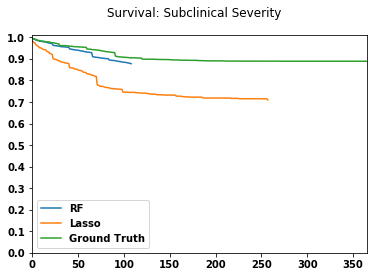

In [125]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Subclinical Severity', 'graphs/survival_subclinical.png')

In [126]:
subclinical_feature_importance_rf, subclinical_feature_importance_lasso = \
                                        get_feature_importance(X.columns, gbsa, rcr, 'SUB')

In [127]:
X = df[df.SUDSy_0 >= 2]
X = X[X.SUDSy_0 <= 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2818, 28) (2818,)


In [128]:
%%time
mild_concordance, gbsa, rsf, rcr = run_models(X, y, 'MILD')

RF Boosted score: 0.5484605703985066
RF score: 0.5574468608212879
Lasso score: 0.5716598975115874
CPU times: user 52.3 s, sys: 817 ms, total: 53.1 s
Wall time: 59.3 s


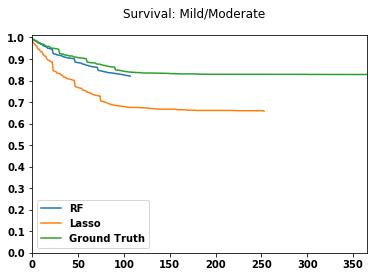

In [129]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Mild/Moderate', 'graphs/survival_mild.png')

In [130]:
mild_feature_importance_rf, mild_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'MILD')

Severe Severity Survival Analysis

In [131]:
X = df[df.SUDSy_0 > 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3964, 28) (3964,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [132]:
%%time
severe_concordance, gbsa, rsf, rcr = run_models(X, y, 'SEVERE')

RF Boosted score: 0.5865868617688385
RF score: 0.5827753330144091
Lasso score: 0.5928526069843887
CPU times: user 1min 46s, sys: 1.51 s, total: 1min 47s
Wall time: 1min 49s


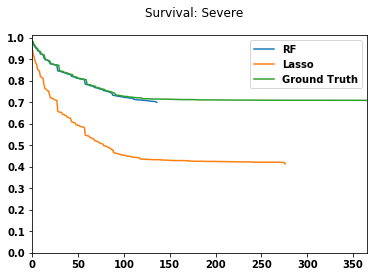

In [133]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Severe', 'graphs/survival_severe.png')

In [134]:
severe_feature_importance_rf, severe_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'SEVERE')

Overall Statistics

In [135]:
overall_concordance = pd.concat([subclinical_concordance, mild_concordance['MILD'], severe_concordance['SEVERE'],  
                                 full_concordance['ALL']], axis=1)
pd.DataFrame(data=overall_concordance)

,Model,SUB,MILD,SEVERE,ALL
0,Random Forest Boosted,0.636527,0.548461,0.586587,0.663435
1,Random Forest,0.611214,0.557447,0.582775,0.657894
2,Lasso,0.647403,0.571660,0.592853,0.667394
3,Dataset Size,3243.000000,2818.000000,3964.000000,10025.000000


In [136]:
overall_feature_importance_lasso = pd.merge(subclinical_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
0,cjsig_0_cd,0.164615,0.164615,0.000000,0.000000,0.000000,0.000000
1,r4ag_0_cd,0.103008,0.103008,0.088799,0.088799,0.087684,0.087684
2,gvsg_cd,0.096805,0.096805,0.023836,0.023836,0.000000,0.000000
3,B2a_0g,0.063857,0.063857,0.000000,0.000000,-0.009964,0.009964
4,dssg_0_cd,0.057678,0.057678,0.000000,0.000000,0.078810,0.078810
5,primsev_cd_2,-0.029294,0.029294,0.000000,0.000000,0.000000,0.000000
6,murder_numg,-0.022921,0.022921,0.000000,0.000000,0.000000,0.000000
7,%_povertyg,0.020477,0.020477,0.060900,0.060900,0.000000,0.000000
8,prsatx_cd,0.019939,0.019939,0.078999,0.078999,0.013262,0.013262
,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs


In [147]:
np.exp(overall_feature_importance_lasso['SEVERE'])

0     1.000000
1     1.091643
2     1.000000
3     0.990085
4     1.081998
5     1.000000
6     1.000000
7     1.000000
8     1.013350
9     1.054957
10    1.008176
11    1.024923
12    1.000000
13    1.000000
14    1.019885
15    1.000000
16    1.107465
17    1.074073
Name: SEVERE, dtype: float64

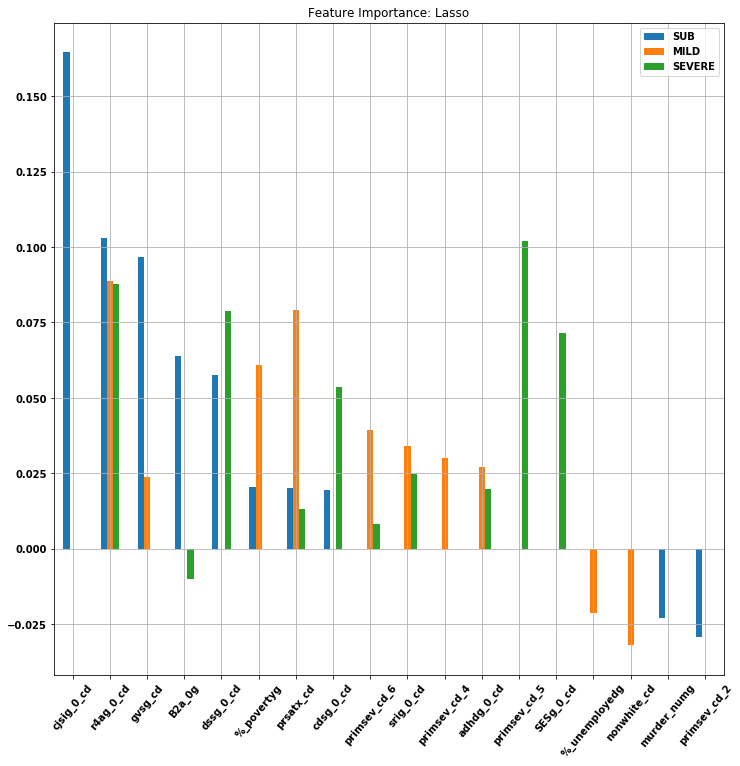

In [137]:
# feature importance for lasso across all ages
plt.rcParams["font.weight"] = "bold"

df = pd.DataFrame({'SUB': overall_feature_importance_lasso['SUB'].tolist(),
                   'MILD': overall_feature_importance_lasso['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_lasso['SEVERE'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: Lasso')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_lasso.png', bbox_inches='tight')

In [138]:
overall_feature_importance_rf = pd.merge(subclinical_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,cjsig_0_cd,0.188282,0.000000,0.044893
1,B2a_0g,0.149700,0.000000,0.043488
2,r4ag_0_cd,0.085076,0.092539,0.147794
3,gvsg_cd,0.079182,0.000000,0.000000
4,prsatx_cd,0.068992,0.103946,0.000000
,Feature,SUB,MILD,SEVERE
5,primsev_cd_4,0.055091,0.066233,0.000000
6,SESg_0_cd,0.054569,0.000000,0.102681
7,%_U18g,0.054183,0.000000,0.000000
8,%_female_householdg,0.051723,0.000000,0.000000


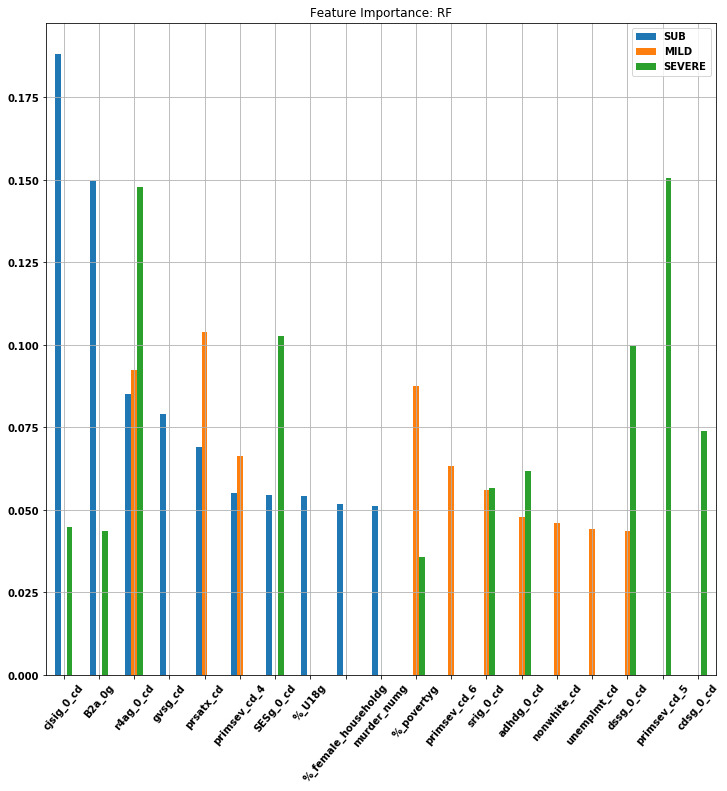

In [139]:
# feature importance for rf across all ages
df = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist(),
                   'MILD': overall_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_rf.png', bbox_inches='tight')

In [140]:
# features in top 10 of both models across all ages
feature_importance_intersection = np.intersect1d(overall_feature_importance_rf['Feature'], 
                                                 overall_feature_importance_lasso['Feature'])
print('Common Features:', *list(feature_importance_intersection), sep =', ')

Common Features:, %_povertyg, B2a_0g, SESg_0_cd, adhdg_0_cd, cdsg_0_cd, cjsig_0_cd, dssg_0_cd, gvsg_cd, murder_numg, nonwhite_cd, primsev_cd_4, primsev_cd_5, primsev_cd_6, prsatx_cd, r4ag_0_cd, srig_0_cd


In [141]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 14 minutes 13 seconds ---
